# Выявление поведения лосс и функции энергии

In [1]:
import albumentations as A
from torch.utils.data import DataLoader, random_split
from datetime import datetime

from src.config import MOT20_EXT_FIRST_AXIS_MEAN, MOT20_EXT_SECOND_AXIS_MEAN
from src.train import get_dataset, get_loaders, save_train_results, _get_loss_name
from src.train.utils import get_config, get_experiments, get_model, display_images, get_binary_accuracy
from src.transforms import get_norm_transform, get_resize_transform
from tqdm import tqdm
import numpy as np
import pandas as pd
from src.models import models_list
from sklearn import preprocessing
import torch
import matplotlib.pyplot as plt 
from copy import deepcopy
from src.train import ContrastiveLoss
from torch.optim import Adam
import sklearn

/home/nick/reidentification/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nick/reidentification/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [2]:
basic_cnn = deepcopy(models_list['basic_cnn'])

In [3]:
basic_cnn

SiameseBasicCNN(
  (cnn1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): AdaptiveAvgPool2d(output_size=(1, 1))
  )
  (fc1): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): Tanh()
    (2): Linear(in_features=256, out_features=2, bias=True)
  )
)

In [4]:
resize_transform = get_resize_transform((MOT20_EXT_FIRST_AXIS_MEAN, MOT20_EXT_SECOND_AXIS_MEAN)) 
norm_transform = get_norm_transform()
transform = A.Compose([resize_transform, norm_transform])

In [5]:
# dataset_config = get_config('mot20_ext-v1d')
dataset_config = {
    'dataset_config': 'mot20_ext-v1d',
    'dataset': 'mot20_ext',
    'dataset_use': 0.01,
    'train_proportion': 0.8,
    'val_proportion': 0.2,
    'batch_size': 16,
    'extra_parameters': {
        'visibility_threshold': 1,
        'negative_proportion': 0.5,
        'frame_distance': 0
    }
}

In [6]:
train_loader, val_loader, _ = get_loaders(dataset_config, transform=transform)

/home/nick/reidentification/.venv/lib/python3.10/site-packages/torch/utils/data/dataset.py:348: UserWarning: Length of split at index 2 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "


In [7]:
len(train_loader), len(val_loader)

(87, 21)

In [8]:
lr = 1e-3
criterion = ContrastiveLoss(margin=1)
optimizer = Adam(basic_cnn.parameters(), lr)
torch.cuda.empty_cache()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

/home/nick/reidentification/.venv/lib/python3.10/site-packages/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


device(type='cpu')

In [9]:
basic_cnn = basic_cnn.to(device)

losses_train = []
accuracies_train = []
losses_val = []
accuracies_val = []
epoch_count = 5


for epoch in range(epoch_count):
    for phase in ['train', 'val']:
        if (phase == 'train'):
            dataloader = train_loader
            # if (scheduler is not None):
            #     scheduler.step()
            basic_cnn.train()
        else:
            dataloader = val_loader
            basic_cnn.eval()
        running_loss = 0.
        running_acc = 0.
        for (x1, x2, y) in tqdm(dataloader):
            x1, x2, y = x1.to(device), x2.to(device), y.to(device)
            optimizer.zero_grad()
            with torch.set_grad_enabled(phase == 'train'):
                distance = basic_cnn(x1, x2)
                loss = criterion(distance, y)
                if (phase == 'train'):
                    loss.backward()
                    optimizer.step()
            running_loss += loss.item()
            # print(distance)
            # считаем аккураси. все что больше тресхолда - 1, меньше - 0
            # d = distance.clone().cpu()
            # d = d.detach().numpy()
            # d = (d - d. min()) / (d. max() - d. min())
            # print(d)
            # running_acc += get_distance_accuracy(
            #     distance.clone(), y, threshold)
        epoch_loss = running_loss / len(dataloader)
        epoch_acc = running_acc / len(dataloader)
        if phase == 'val':
            losses_val.append(epoch_loss)
            # accuracies_val.append(epoch_acc)
        else:
            losses_train.append(epoch_loss)
            # accuracies_train.append(epoch_acc)

 18%|█▊        | 16/87 [00:03<00:15,  4.69it/s]


KeyboardInterrupt: 

In [ ]:
dt = datetime.now()

torch.save({
    'epoch': epoch,
    'model_state_dict': basic_cnn.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': epoch_loss,
    'model_name': basic_cnn.name,
}, f'./models/{basic_cnn.name}_{dt.strftime("%d.%m_%H:%M")}.pth')
print(f'Model saved at {basic_cnn.name}.pth')

save_train_results(
    model_name=basic_cnn.name,
    datetime=dt,
    epoch_count=epoch_count,
    lr=lr,
    optimizer=str(optimizer).split(' ')[0],
    loss_name=_get_loss_name(criterion),
    val_losses=losses_val,
    val_accuracies=[-1],
    gamma=-1,#scheduler.gamma if (scheduler) else -1,
    step_size=-1,#scheduler.step_size if (scheduler) else -1,
    config=dataset_config,
    # extra_parameters={
    #     'threshold': threshold
    # },
    train_accuracies=accuracies_train,
    train_losses=losses_train
)

Model saved at basic_cnn.pth


In [ ]:
losses_val

[0.39711545904477435,
 0.4451860969974881,
 0.3931177251395725,
 0.3892160029638381,
 0.3795363846279326]

## Проверим что модель выдаст на валидации после обучения

In [ ]:
distances = []
for x1, x2, y in tqdm(val_loader):
    x1, x2, y = x1.to(device), x2.to(device), y.to(device)
    # нам не нужно считать градиент для предсказания
    with torch.no_grad():
        d = basic_cnn(x1, x2)
    # убираем из видеопамяти
    distances.append((d.cpu(), y.cpu()))
    # удаляем
    del d
    del y
    # очищаем кэш
    torch.cuda.empty_cache()
    # d = 1 if (d > threshold) else 0

# acc = acc / len(test_loader)

100%|██████████| 21/21 [00:00<00:00, 23.09it/s]


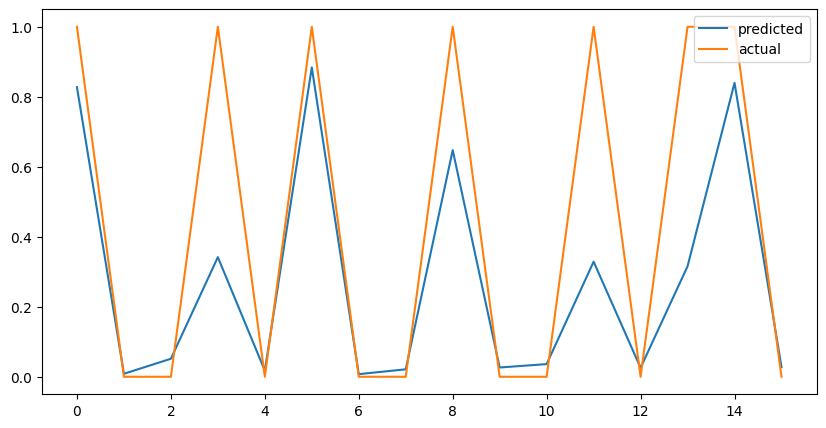

In [ ]:
plt.rcParams['figure.figsize'] = [10, 5]
plt.plot(range(len(distances[0][0])), distances[0][0].reshape(1, 16)[0].numpy(), distances[0][1].numpy())
plt.legend(['predicted', 'actual'])

21it [00:00, 1320.55it/s]


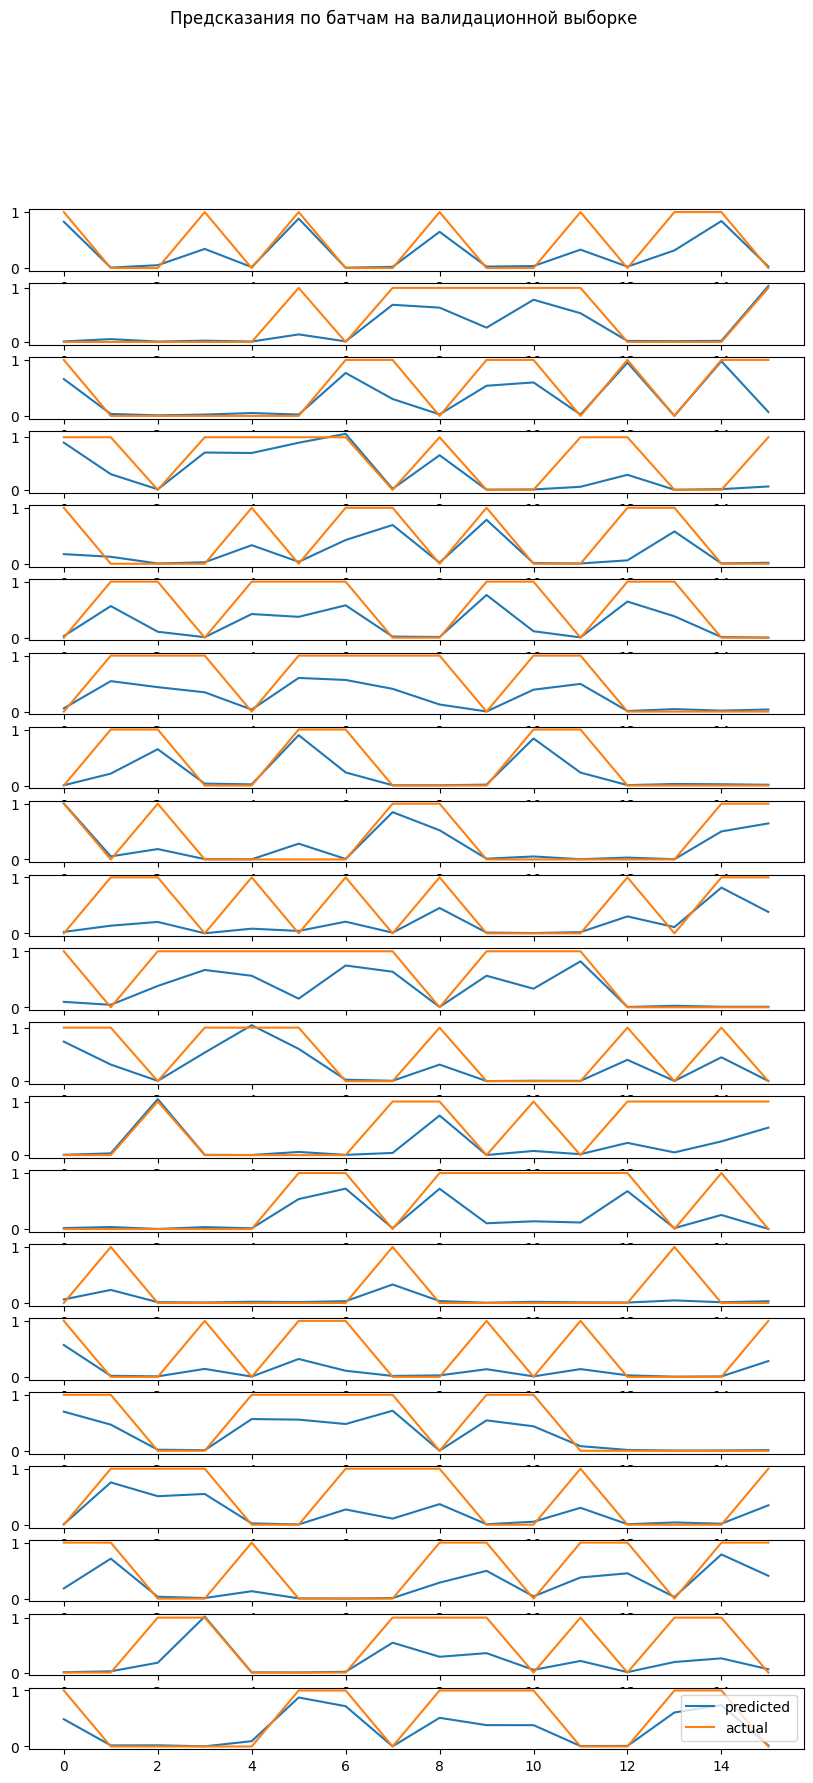

In [ ]:
plt.rcParams['figure.figsize'] = [10, 20]
fig, axs = plt.subplots(len(distances))
fig.suptitle('Предсказания по батчам на валидационной выборке')
for batch, i in tqdm(zip(distances, range(len(distances)))):
    axs[i].plot(range(len(batch[0])), batch[0].reshape(1, 16)[0].numpy(), batch[1].numpy())
plt.legend(['predicted', 'actual'])

In [ ]:
plt.rcParams['figure.figsize'] = [10, 5]

## Анализ объектов с кривым результатом

## Анализ на тесте

In [ ]:
test_dataset_config = get_config('mot20_ext-test-v2')
test_dataset_config

{'dataset_config': 'mot20_ext-test-v2',
 'dataset': 'mot20_ext_test',
 'dataset_use': 0.1,
 'train_proportion': 1.0,
 'val_proportion': 0.0,
 'test_proportion': 0.0,
 'batch_size': 1,
 'extra_parameters': {'visibility_threshold': 1.0,
  'negative_proportion': 0.5,
  'frame_distance': 0}}

In [ ]:
test_set, _ = random_split(get_dataset(test_dataset_config, transform), [
                          test_dataset_config['dataset_use'], 1 - test_dataset_config['dataset_use']])

In [ ]:
test_loader = DataLoader(test_set)
len(test_loader)

6946

In [ ]:
test_distances = []
for x1, x2, y in tqdm(test_loader):
    x1, x2, y = x1.to(device), x2.to(device), y.to(device)
    # нам не нужно считать градиент для предсказания
    with torch.no_grad():
        d = basic_cnn(x1, x2)
    # убираем из видеопамяти
    test_distances.append((d.cpu(), y.cpu()))
    # удаляем
    del d
    del y
    # очищаем кэш
    torch.cuda.empty_cache()
    # d = 1 if (d > threshold) else 0

# acc = acc / len(test_loader)

100%|██████████| 6946/6946 [00:28<00:00, 243.97it/s]


In [ ]:
d = torch.tensor(test_distances[:100])
d.shape
res = d.T

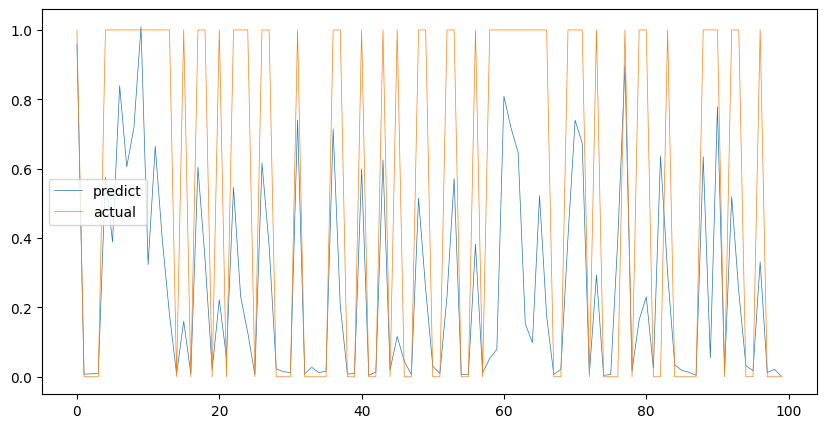

In [ ]:
plt.plot(range(res.shape[1]), np.array(res[0]), np.array(res[1]), linewidth=0.5)
plt.legend(['predicted', 'actual'])

## Анализ по классам

In [ ]:
td = torch.tensor(test_distances)
td.detach()

tensor([[0.9576, 1.0000],
        [0.0073, 0.0000],
        [0.0084, 0.0000],
        ...,
        [0.0049, 0.0000],
        [0.0100, 0.0000],
        [0.1771, 1.0000]])

In [ ]:
df = pd.DataFrame(td, columns=['predicted', 'actual'])
df

,predicted,actual
0,0.957611,1.0
1,0.007283,0.0
2,0.008450,0.0
3,0.010509,0.0
4,0.574304,1.0
...,...,...
6941,0.663116,1.0
6942,0.021064,0.0
6943,0.004913,0.0
6944,0.009956,0.0


In [ ]:
class_zero = df[df['actual'] == 0].reset_index(drop=True)
class_zero

,predicted,actual
0,0.007283,0.0
1,0.008450,0.0
2,0.010509,0.0
3,0.007269,0.0
4,0.008176,0.0
...,...,...
3468,0.027181,0.0
3469,0.005644,0.0
3470,0.021064,0.0
3471,0.004913,0.0


In [ ]:
class_one = df[df['actual'] == 1].reset_index(drop=True)
class_one

,predicted,actual
0,0.957611,1.0
1,0.574304,1.0
2,0.388635,1.0
3,0.838956,1.0
4,0.605368,1.0
...,...,...
3468,0.783731,1.0
3469,0.269176,1.0
3470,0.592254,1.0
3471,0.663116,1.0


<Axes: >

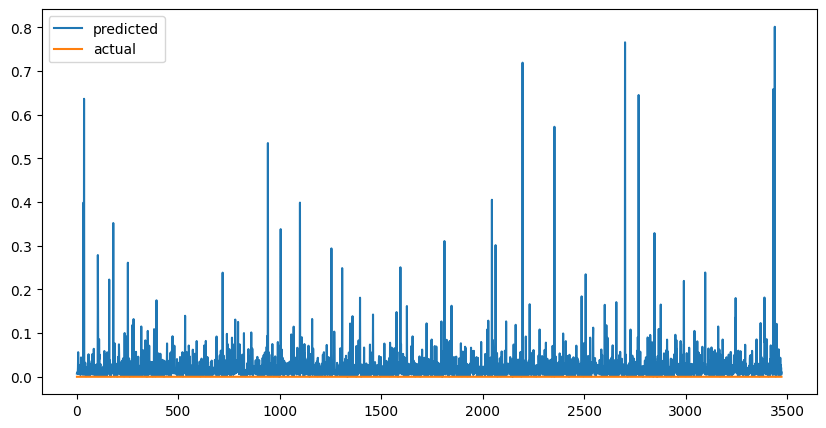

In [ ]:
class_zero.plot()

<Axes: >

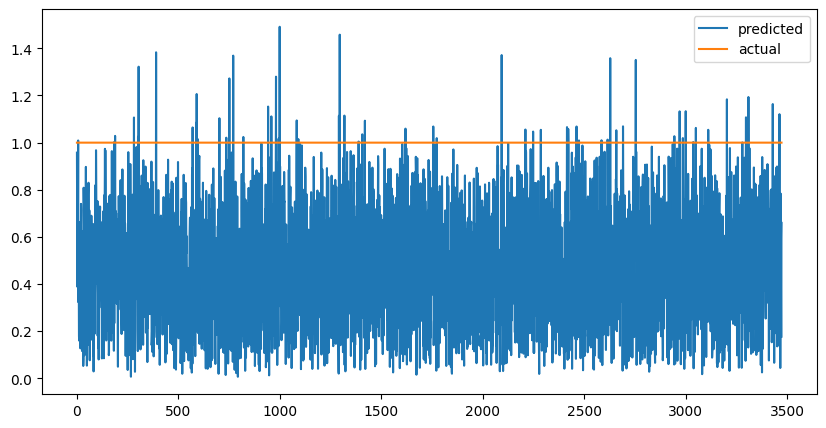

In [ ]:
class_one.plot()

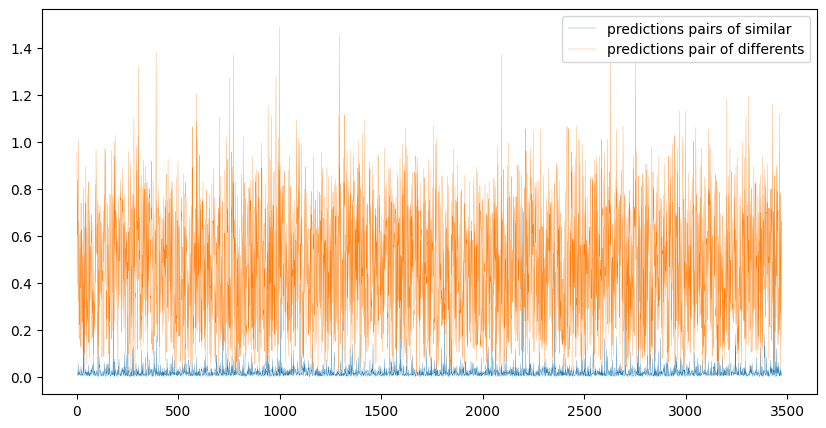

In [ ]:
plt.plot(list(range(len(class_zero))), class_zero['predicted'], class_one['predicted'], linewidth=0.2)
plt.legend(['predictions pairs of similar', 'predictions pair of differents'])

Нужно разделить эти два класса с максимальным аккураси

In [ ]:
len(list(range(len(class_zero)))), len(class_zero['predicted']), len(class_one['predicted'])

(3473, 3473, 3473)

## Расчет тресхолд по валидации

Рассчитывать тресхолд нужно во время обучения и сразу вычислять по нему аккураси

In [ ]:
# распаковали все батчи
res = torch.tensor([[], []])
for batch in tqdm(distances):
    a, b = torch.tensor(np.asarray(batch[0])), torch.tensor(np.asarray(batch[1]))
    a = a.reshape(-1)
    res = torch.hstack([res, torch.vstack([a, b])])

res.shape

100%|██████████| 21/21 [00:00<00:00, 7290.22it/s]


torch.Size([2, 336])

<Axes: >

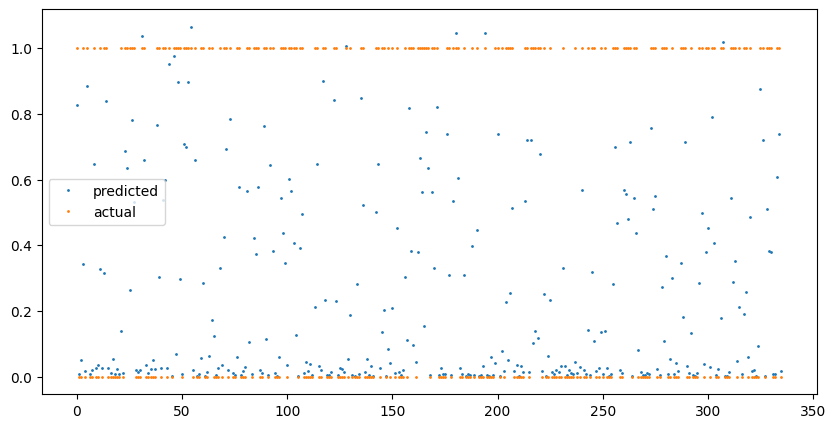

In [ ]:
df = pd.DataFrame(res.T, columns=['predicted', 'actual'])
df.plot(linestyle="", marker="o", markersize=1)

In [ ]:
class_zero_val = df[df['actual'] == 0]['predicted']
class_ones_val = df[df['actual'] == 1]['predicted']

Text(0, 0.5, 'предсказанное значение')

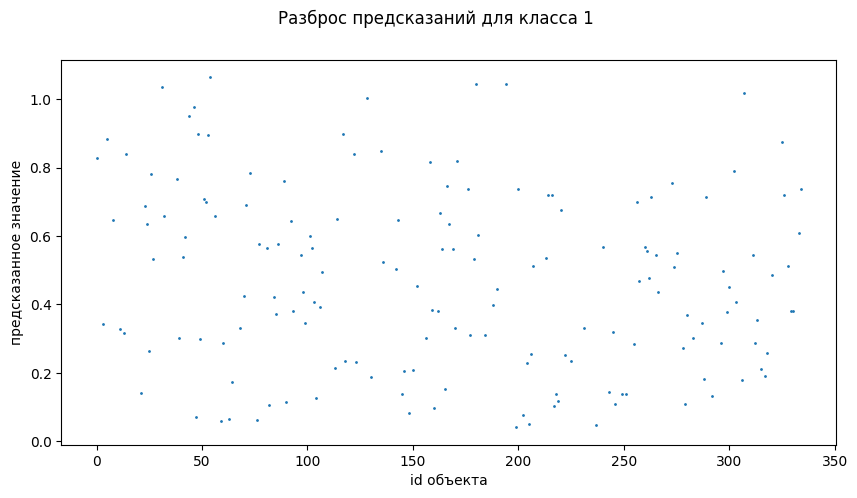

In [ ]:
fig, ax = plt.subplots()
class_ones_val.plot(linestyle="", marker="o", markersize=1)
fig.suptitle('Разброс предсказаний для класса 1')
plt.xlabel('id объекта')
plt.ylabel('предсказанное значение')

Text(0, 0.5, 'предсказанное значение')

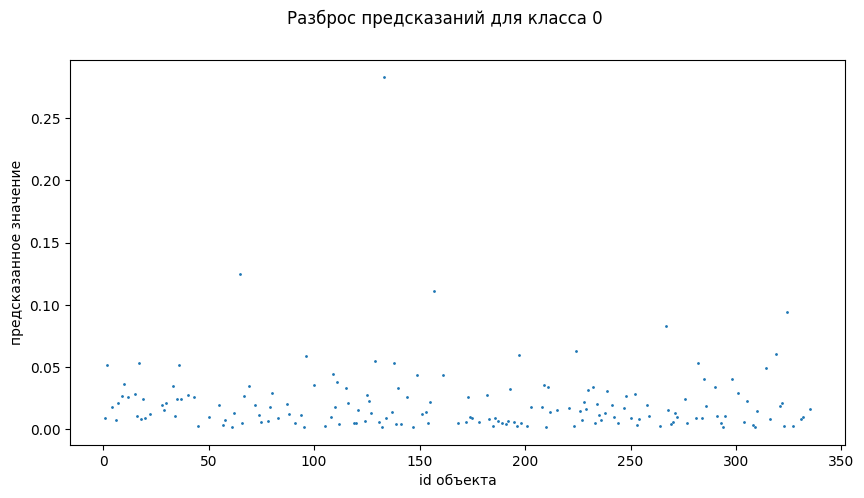

In [ ]:
fig, ax = plt.subplots()
class_zero_val.plot(linestyle="", marker="o", markersize=1)
fig.suptitle('Разброс предсказаний для класса 0')
plt.xlabel('id объекта')
plt.ylabel('предсказанное значение')

In [ ]:
threshold = (class_zero_val.mean() + class_zero_val.mean()) / 2
threshold

0.02110697329044342

In [ ]:
FP = len(class_zero_val[class_zero_val > threshold]) 
FN = len(class_ones_val[class_ones_val < threshold])
acc = 1 -(FP + FN) / (len(class_zero_val) + len(class_ones_val))
acc

0.8273809523809523